<a href="https://colab.research.google.com/github/KylerJacobs/Business-Data-Analytics-Intelligence/blob/main/GCI_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries, Dates, and Data

In [ ]:
#Challenge: How much did the Volkswagen C02 scandal in Sept. 2015 effect Volkswagen's stock market value?

In [1]:
#Install libraries
!pip install yfinance
!pip install tfcausalimpact

In [13]:
#Import Libraries
import yfinance as yf
import pandas as pd
from causalimpact import CausalImpact
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
#Dates
#Start day of the treatment is September 2015
training_start = "2014-01-08"
training_end = "2015-08-26"
treatment_start = "2015-09-02"
treatment_end = "2015-09-30"
end_stock = "2015-10-02"

In [55]:
#Download VW stock
y = ["VOW.DE"]
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = "1wk")
y = y["Adj Close"].rename("y")
y.head(1)

[*********************100%***********************]  1 of 1 completed


Date
2014-01-06    125.620445
Name: y, dtype: float64

In [56]:
#Download Control Groups
#pick stock tickers not in the automotive industry as they may have been impacted by VW scandal treatment
stocks = ["META", "DIS", "NVS", "AMZ"]
X = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1wk")
X = X.iloc[:,:len(stocks)]
X.columns = X.columns.droplevel()
X.head()
#We ned t be sure dates are linng up. since we are working with stock, holidays and weekends can get in our way
#the first bit of data from y needs to be the same date as the X first data point.

[*********************100%***********************]  4 of 4 completed


,AMZ,DIS,META,NVS
Date,,,,
2014-01-06,290.200012,69.382652,57.939999,50.780766
2014-01-13,296.000000,68.084999,56.299999,50.680878
2014-01-20,287.000000,66.925392,54.450001,49.844315
2014-01-27,271.299988,66.824150,62.570000,49.363605
2014-02-03,260.450012,69.640327,64.320000,50.518566


In [44]:
#Combine everything
#Start by dealing with timezone issues
X.index = X.index.tz_localize(None)
#Create data frame
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,AMZ,DIS,META,NVS
Date,,,,,
2014-01-06,125.620445,290.200012,69.382637,57.939999,50.780773
2014-01-13,127.199532,296.000000,68.084991,56.299999,50.680885
2014-01-20,119.239502,287.000000,66.925377,54.450001,49.844315
2014-01-27,116.242401,271.299988,66.824150,62.570000,49.363602
2014-02-03,117.628174,260.450012,69.640335,64.320000,50.518562


#Correlation Matrix

In [45]:
#Subset the training data
df_training = df[df.index <= training_end]
df_training.tail()

,y,AMZ,DIS,META,NVS
Date,,,,,
2015-07-13,136.411545,445.350006,111.423401,94.970001,70.214958
2015-07-27,123.860619,484.250000,112.492073,94.010002,68.847946
2015-08-10,121.135078,478.299988,100.455421,94.419998,68.005180
2015-08-17,111.040497,445.049988,92.655975,86.059998,64.740295
2015-08-24,114.741852,465.399994,96.068237,91.010002,65.264526


<Axes: >

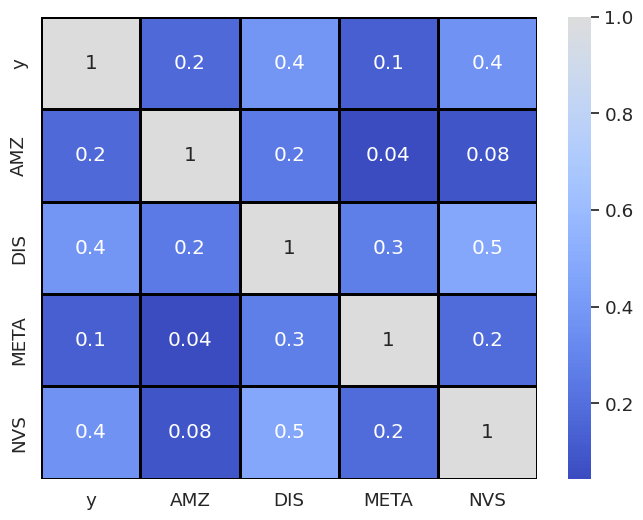

In [46]:
#Heatmap for variable visualization
plt.figure(figsize = (8, 6))
sns.set(font_scale = 1.2)
sns.heatmap(data = df_training.pct_change().dropna().corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'coolwarm',
            center = True,
            linewidth = 1,
            linecolor = 'black')
#In the heatmap, we want to observe the y and see how it compares to the other stocks
#Looks like META is a very low correlation so we should remove that variable and AMZ

In [48]:
#Prep final datafram
df_final = df.drop(columns = ['META', 'AMZ'])
df_final.head()
#Only having two other variables is alright. typically do not want less than 2 or 3

,y,DIS,NVS
Date,,,
2014-01-06,125.620445,69.382637,50.780773
2014-01-13,127.199532,68.084991,50.680885
2014-01-20,119.239502,66.925377,49.844315
2014-01-27,116.242401,66.824150,49.363602
2014-02-03,117.628174,69.640335,50.518562


#Google Causal Impact

In [63]:
#get first and last dates
print(df_final.head(1))
print(df_final.tail(10))

                     y        DIS        NVS
Date                                        
2014-01-06  125.620445  69.382637  50.780773
                     y         DIS        NVS
Date                                         
2015-07-13  136.411545  111.423401  70.214958
2015-07-27  123.860619  112.492073  68.847946
2015-08-10  121.135078  100.455421  68.005180
2015-08-17  111.040497   92.655975  64.740295
2015-08-24  114.741852   96.068237  65.264526
2015-08-31  107.641983   94.652718  62.742867
2015-09-07  111.881706   97.943100  64.070068
2015-09-14  108.584152   96.405701  64.136421
2015-09-21   77.761993   94.024635  60.592827
2015-09-28   68.071190   96.555695  61.893475


In [71]:
#Dates
#Start day of the treatment is September 2015
#We were getting codes from using the dates at the top of the notebook
#above we checked when our dates started and ended and now can use the new dates for our CI
training_start = "2014-01-06"
training_end = "2015-08-31"
treatment_start = "2015-09-07"
treatment_end = "2015-09-28"
end_stock = "2015-10-02"

In [72]:
#Define pre and post periods
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

In [73]:
#GCI
impact = CausalImpact(data = df_final,
                      pre_period = pre_period,
                      post_period = post_period)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


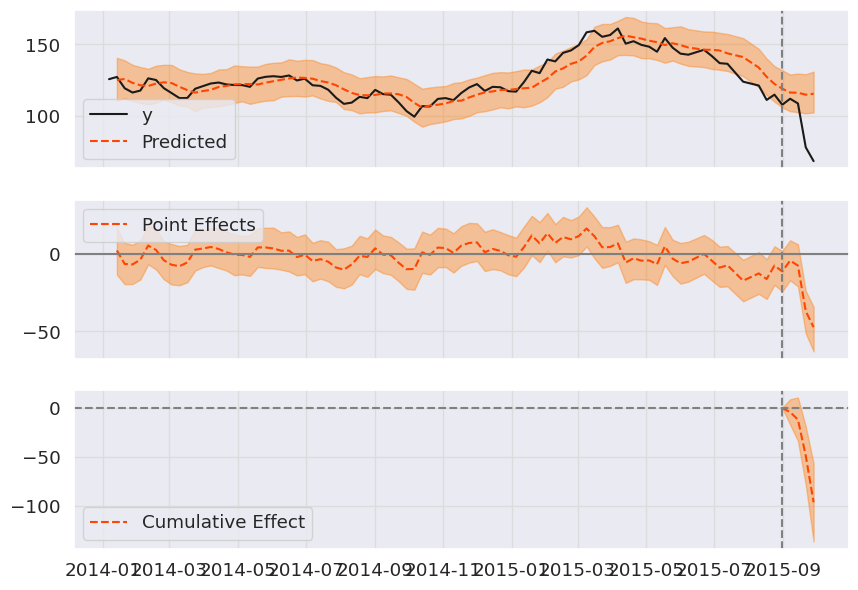

In [75]:
#Output
impact.plot()
#interpretation:
  #orange line is our "what if" based on the two variables 'DIS' and 'NVS'
  #Black line represents VW stock
#We use the middle graph to interpret the delta from our y and x variables from top graph
#steep drop occured in VW price a week or so after the treatment
#the final graph does not work with relative KPI's like price or in our case stock price

In [76]:
#Summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.57              366.3
Prediction (s.d.)         115.61 (5.01)      462.42 (20.06)
95% CI                    [105.22, 124.88]   [420.89, 499.51]

Absolute effect (s.d.)    -24.03 (5.01)      -96.13 (20.06)
95% CI                    [-33.3, -13.65]    [-133.21, -54.59]

Relative effect (s.d.)    -20.79% (4.34%)    -20.79% (4.34%)
95% CI                    [-28.81%, -11.81%] [-28.81%, -11.81%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [77]:
#Full report
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 91.57. By contrast, in the absence of an
intervention, we would have expected an average response of 115.61.
The 95% interval of this counterfactual prediction is [105.22, 124.88].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -24.03 with a 95% interval of
[-33.3, -13.65]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 366.3.
By contrast, had the intervention not taken place, we would have expected
a sum of 462.42. The 95% interval of this prediction is [420.89, 499.51].


The above results are given in terms of absolute numbers. In relative
terms, the response va